## Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load the Raw Data

In [3]:
df = pd.read_csv('../data/raw_train.csv')

## Handling Missing Values

In [4]:
# Dropping columns with high missing values
total_rows= len(df)
missing_values = df.isnull().sum()
missing_percentage = (missing_values/total_rows)*100

print("Missing values percentage per column (before cleaning): ")
print(missing_percentage.sort_values(ascending= False))
print("-"*50)

columns_to_drop= missing_percentage[missing_percentage>80].index.tolist()
print("Columns identified to be dropped based on > 80% missing data: ")
print(columns_to_drop)

df.drop(columns= columns_to_drop, axis=1, inplace= True)
print("\nHigh missing value columns have been dropped successfully.")
print("-"*50)

# Imputing the remaning missing values
# For numerical features, we will use the median to fill missing values
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice', 'SalePrice_Log'])
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
print("\nNumerical columns missing values filled with median.")

# For categorical/ordinal features, "NA" often means "None"
cat_cols = df.select_dtypes(include=['object']).columns
cols_fill_none= ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'MasVnrType']

cols_fill_mode= [col for col in cat_cols if col not in cols_fill_none]

df[cols_fill_none]= df[cols_fill_none].fillna('None')
for col in cols_fill_mode:
    df[col]= df[col].fillna(df[col].mode()[0])

print("\nCategorical missing values imputed successfully based on context.")
print("-"*50)


Missing values percentage per column (before cleaning): 
PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
MasVnrType       59.726027
                   ...    
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
SalePrice_Log     0.000000
Length: 82, dtype: float64
--------------------------------------------------
Columns identified to be dropped based on > 80% missing data: 
['Alley', 'PoolQC', 'Fence', 'MiscFeature']

High missing value columns have been dropped successfully.
--------------------------------------------------

Numerical columns missing values filled with median.

Categorical missing values imputed successfully based on context.
--------------------------------------------------


## Analyzing Correaltions

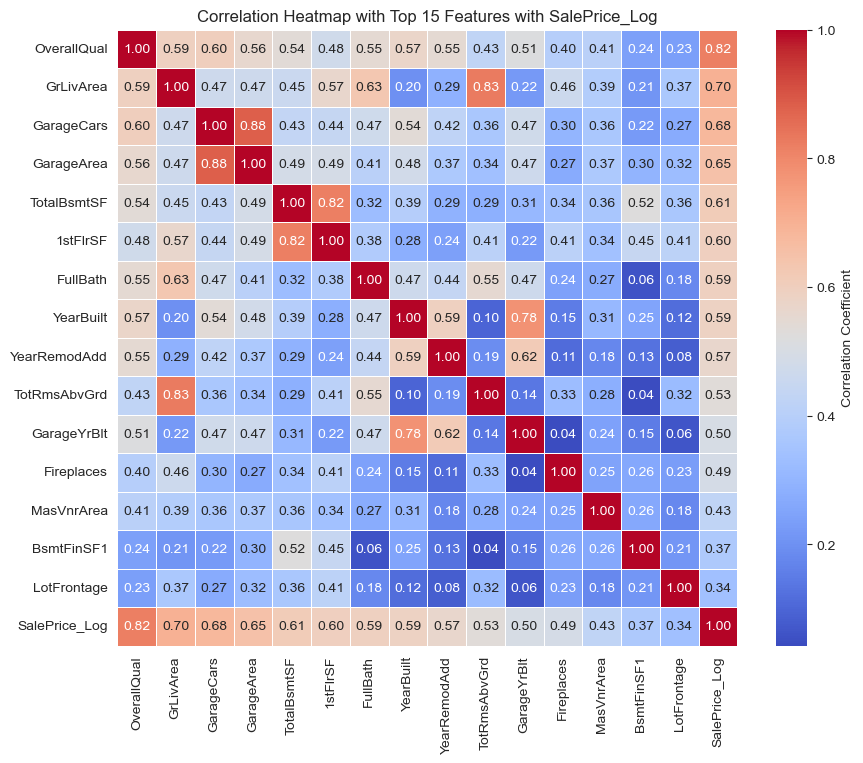

In [5]:
# Select only numerical columns for correlation analysis
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice'])
correlations = df[numerical_features].corr()['SalePrice_Log'].sort_values(ascending=False)

top_15_features= correlations[1:16].index.tolist()
corr_df= df[top_15_features + ['SalePrice_Log']]
corr_matrix= corr_df.corr()

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
sns.heatmap(corr_matrix, annot= True, cmap='coolwarm', fmt= '.2f', linewidths= .5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap with Top 15 Features with SalePrice_Log')
plt.show()

We add the `SalePrice_Log` column at the last column of the heatmap so that it helps us visulaize the correlation of every other feature with the target varibale at a glance.

### Feature Selection Based on Correlation with SalePrice_Log

To identify the most relevant numerical predictors of house prices, I computed the Pearson correlation of each feature with the log-transformed SalePrice. The top 15 features were selected for visualization.

#### Strongly Correlated Features
- **OverallQual (0.82):** Rates the overall material and finish of the house.  
- **GrLivArea (0.70):** Above grade (ground) living area square feet.  

#### Moderately Strong Features
- **GarageCars (0.68):** Size of garage in car capacity. 
- **GarageArea (0.65):** Size of garage in square feet.  
- **TotalBsmtSF (0.61):** Total square feet of basement area.  
- **1stFlrSF (0.60):** First Floor square feet.  

#### Medium Correlation Features
- **FullBath (0.59)**  
- **YearBuilt (0.59)**  
- **YearRemodAdd (0.57)**  
- **TotRmsAbvGrd (0.53)**  
- **GarageYrBuilt (0.50)**
- **Fireplaces (0.49)**  

#### Weaker Features
- **MasVnrArea (0.43)**  
- **BsmtFinSF1 (0.38)**  
- **LotFrontage (0.34)**  

### Decision
For modeling, I will prioritize the strongly and moderately correlated features, while weaker ones may still be useful in combination with others or after regularization.  
Categorical features were not included in this correlation analysis, but they will be encoded and evaluated separately using feature importance in tree-based models.

## Handling Outliers

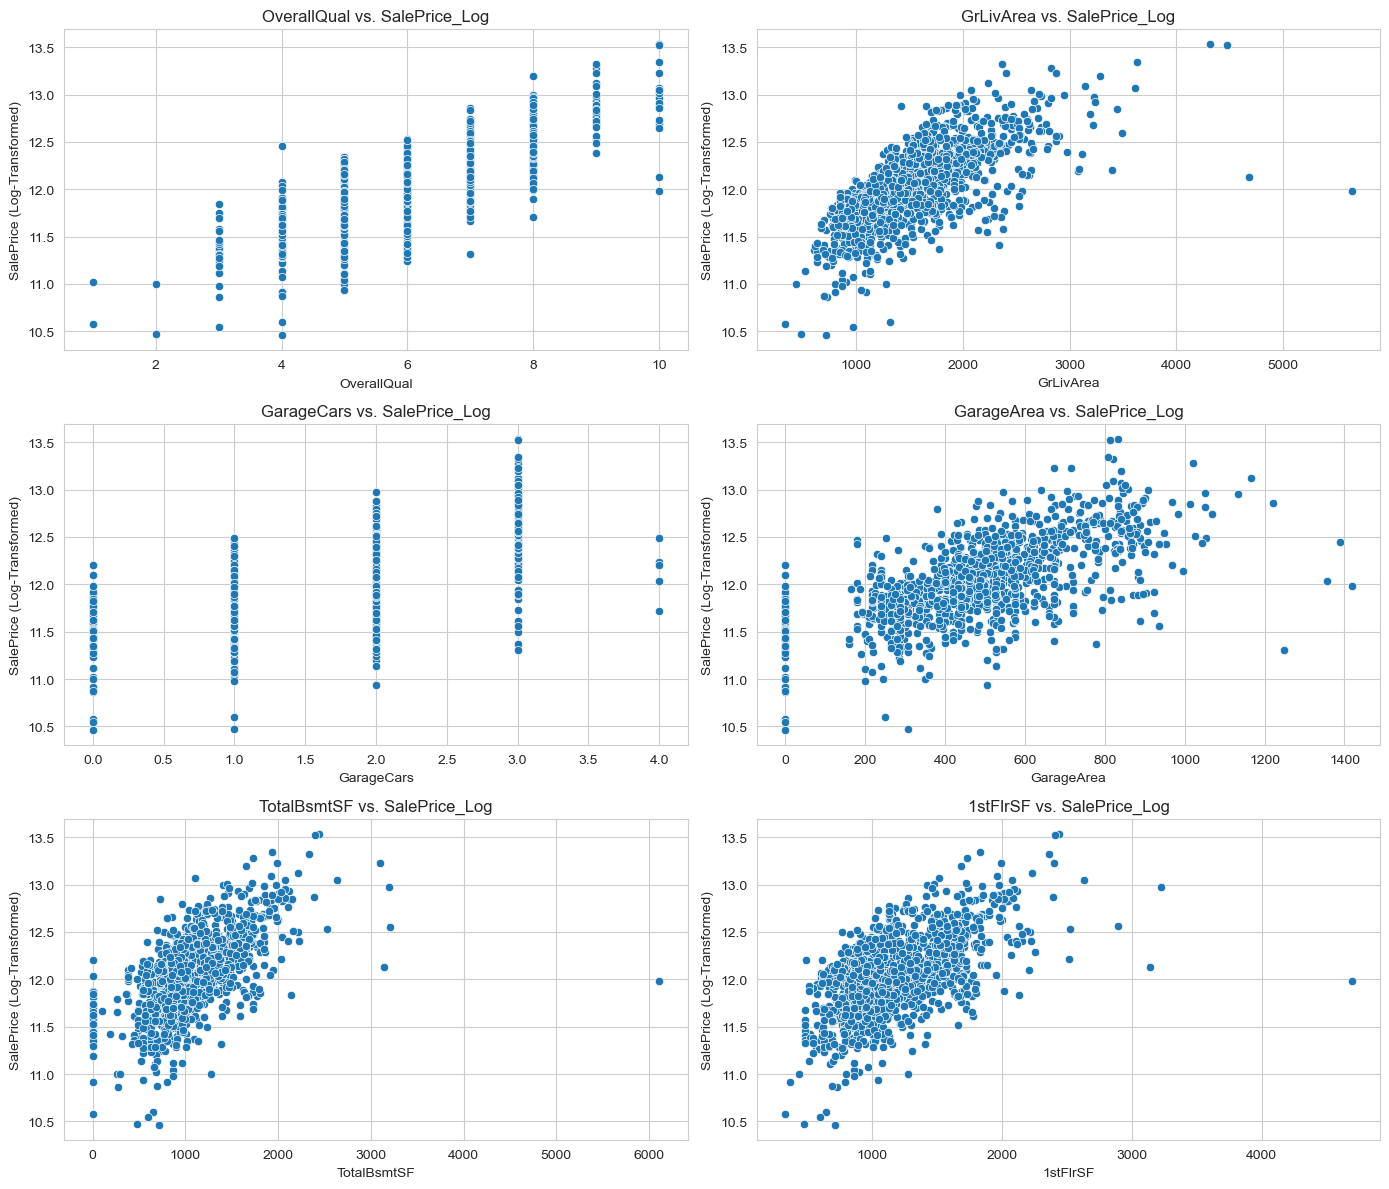

In [6]:
# Visualize the Outliers
fig, axes= plt.subplots(3,2, figsize=(14,12))
axes= axes.flatten()

features_to_plot=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x= feature, y='SalePrice_Log', data= df, ax= axes[i])
    axes[i].set_title(f'{feature} vs. SalePrice_Log')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice (Log-Transformed)')

plt.tight_layout()
plt.show()


I visualized the following features:  
[`OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`]

- **OverallQual** and **GarageCars** are discrete-like variables → not suitable for outlier removal.  
- **GrLivArea, TotalBsmtSF, GarageArea, 1stFlrSF** showed strong correlation with `SalePrice_Log` *and* have clear extreme outliers that distort model training.  

👉 Therefore, I will remove outliers only from:  
[`GrLivArea`, `TotalBsmtSF`, `GarageArea`, `1stFlrSF`]

In [7]:
print("Removing identified outliers....")

df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice_Log']<12.5)].index, inplace= True)
df.drop(df[(df['TotalBsmtSF']>2500) & (df['SalePrice_Log']<12.0)].index, inplace= True)
df.drop(df[df['GarageArea']>1200].index, inplace= True)
df.drop(df[(df['1stFlrSF']>2500) & (df['SalePrice_Log']<12.0)].index, inplace= True)

print("Outliers removed successfully.")

Removing identified outliers....
Outliers removed successfully.


## Encoding Categorical Variable

In [8]:
# Identify ordinal columns and define their order
ordinal_cols = ['Street', 'PavedDrive', 'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu','GarageQual', 'GarageCond']

street_map= {'Pave': 2, 'Grvl': 1}
paved_drive_map= {'Y': 3, 'P': 2, 'N': 1}
lot_shape_map= {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
utilities_map= {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}
land_slope_map= {'Gtl': 3, 'Mod': 2, 'Sev': 1}
qual_map= {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
bsmt_fin_map= {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
bsmt_exposure_map= {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
fire_place_map= {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
garage_map= {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

ordinal_mappings = {
    'Street': street_map,
    'PavedDrive': paved_drive_map,
    'LotShape': lot_shape_map,
    'Utilities': utilities_map,
    'LandSlope': land_slope_map,
    'ExterQual': qual_map,
    'ExterCond': qual_map,
    'BsmtQual': qual_map,
    'BsmtCond': qual_map,
    'BsmtExposure': bsmt_exposure_map,
    'BsmtFinType1': bsmt_fin_map,
    'BsmtFinType2': bsmt_fin_map,
    'HeatingQC': qual_map,
    'KitchenQual': qual_map,
    'FireplaceQu': fire_place_map,
    'GarageQual': garage_map,
    'GarageCond': garage_map
}

print(f"Number of columns before encoding: {df.shape[1]}")
for col, mapping in ordinal_mappings.items():
    if col in df.columns:
        df[col]= df[col].map(mapping).fillna(0)

print("Ordinal encoding completed.")


Number of columns before encoding: 78
Ordinal encoding completed.


In [9]:
# Identify nominal columns by selecting all remaning 'object' type columns
nominal_col= df.select_dtypes(include= ['object']).columns
print("Nominal features to be One-Hot Encoded: ")
print(nominal_col.tolist())

df= pd.get_dummies(df, columns= nominal_col, drop_first= True)
print("\nOne-Hot Encoding completed.")
print(f"Number of columns after encoding: {df.shape[1]}")
print("\nFirst 5 rows of the encoded DataFrame:")
print(df.head())


Nominal features to be One-Hot Encoded: 
['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']

One-Hot Encoding completed.
Number of columns after encoding: 202

First 5 rows of the encoded DataFrame:
   Id  MSSubClass  LotFrontage  LotArea  Street  LotShape  Utilities  \
0   1          60         65.0     8450       2         4          4   
1   2          20         80.0     9600       2         4          4   
2   3          60         68.0    11250       2         3          4   
3   4          70         60.0     9550       2         3          4   
4   5          60         84.0    14260       2         3          4   

   LandSlope  OverallQual  OverallCond  ...  SaleType_ConLI  SaleType_ConLw  \
0          3            7         

## Checking Feature Skewness

In [10]:
numerical_features= df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice', 'SalePrice_Log'])

skewness= df[numerical_features].skew().sort_values(ascending=False)
highly_skewd_features= skewness[abs(skewness)>0.75]

print("Skewness of numerical features:")
print(skewness)
print("\nHighly skewed features to be transformed: ")
print(highly_skewd_features)


Skewness of numerical features:
MiscVal          24.455241
PoolArea         15.926839
LotArea          12.631848
3SsnPorch        10.282620
LowQualFinSF      8.992169
KitchenAbvGr      4.477847
BsmtFinSF2        4.245246
ScreenPorch       4.112351
BsmtHalfBath      4.093529
BsmtFinType2      3.288453
EnclosedPorch     3.081741
MasVnrArea        2.706973
OpenPorchSF       2.338436
LotFrontage       1.734288
WoodDeckSF        1.548523
MSSubClass        1.403427
ExterCond         1.395298
BsmtExposure      1.110803
GrLivArea         1.015551
BsmtUnfSF         0.912421
1stFlrSF          0.889323
ExterQual         0.822439
2ndFlrSF          0.808781
BsmtFinSF1        0.762180
OverallCond       0.689451
HalfBath          0.678852
TotRmsAbvGrd      0.662312
Fireplaces        0.634422
BsmtFullBath      0.591948
TotalBsmtSF       0.507782
KitchenQual       0.379087
MoSold            0.216378
BedroomAbvGr      0.210471
OverallQual       0.197656
YrSold            0.096220
FullBath          0.031

In [11]:
# Apply a log-transformation to highly skewed features
for feature in highly_skewd_features.index:
    df.loc[df[feature]<0, feature]=0
    df.loc[:, feature] = np.log1p(df[feature])

print("Highly skewed features have been log-transformed.")


Highly skewed features have been log-transformed.


## Scaling

In [12]:
numerical_features= df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice', 'SalePrice_Log'])

scaler= StandardScaler()
df[numerical_features]= scaler.fit_transform(df[numerical_features])

print("First 5 rows after scaling:")
print(df.head())


First 5 rows after scaling:
   Id  MSSubClass  LotFrontage   LotArea    Street  LotShape  Utilities  \
0   1    0.424772    -0.071495 -0.126103  0.058742  0.662443   0.026234   
1   2   -1.125716     0.586976  0.122803  0.058742  0.662443   0.026234   
2   3    0.424772     0.071430  0.432201  0.058742 -0.906747   0.026234   
3   4    0.645500    -0.324797  0.112616  0.058742 -0.906747   0.026234   
4   5    0.424772     0.741959  0.894712  0.058742 -0.906747   0.026234   

   LandSlope  OverallQual  OverallCond  ...  SaleType_ConLI  SaleType_ConLw  \
0   0.216585     0.661863    -0.520409  ...           False           False   
1   0.216585    -0.068295     2.175582  ...           False           False   
2   0.216585     0.661863    -0.520409  ...           False           False   
3   0.216585     0.661863    -0.520409  ...           False           False   
4   0.216585     1.392022    -0.520409  ...           False           False   

   SaleType_New  SaleType_Oth  SaleType_WD  Sa

## Save the Cleaned Dataset and the Pre-Processors

In [13]:
df.to_csv('../data/processed_train.csv', index= False)
print("Processed data saved to '../data/processed_train.csv'")

Processed data saved to '../data/processed_train.csv'


In [ ]:
deployment_dir = '../Deployment_Artifacts'
if not os.path.exists(deployment_dir):
    os.makedirs(deployment_dir)
    print(f"Created deployment directory!")

joblib.dump(scaler, f'{deployment_dir}/scaler.joblib')
joblib.dump(ordinal_mappings, f'{deployment_dir}/ordinal_mappings.joblib')
final_features_columns= df.drop(columns=['Id', 'SalePrice', 'SalePrice_Log']).columns.tolist()
joblib.dump(final_features_columns, f'{deployment_dir}/final_features_columns.joblib')
print("\nDeployment artifacts (scaler, mappings, feature list) saved successfully!")



Deployment artifacts (scaler, mappings, feature list) saved successfully!
